In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick

In [2]:
# Loading mapping files
mapping_to_token = pd.read_csv("../csv_files/apache_csv/mapping_token.csv")
mapping_to_ast = pd.read_csv("../csv_files/apache_csv/mapping_ast.csv")
mapping_to_rel_ast = pd.read_csv("../csv_files/apache_csv/mapping_relative_ast.csv")
mapping_to_comp_sort_ast = pd.read_csv("../csv_files/apache_csv/mapping_sorted_comp_ast.csv")

mapping = {"token" : mapping_to_token, "ast" : mapping_to_ast, "relative_ast" : mapping_to_rel_ast, "comp_sorted_ast" : mapping_to_comp_sort_ast}

d_type = {"commit_hash" : "str", 	"num_additions" : int,	"num_deletions": int, "filename" : "str"}

# Function for loading data
def load_data(file):
    df = pd.read_csv(file)
    df = df[df.filename.str.endswith(".java")]
    return pd.DataFrame({"commit_hash": df.commit_hash, "changes": pd.to_numeric(df.num_additions) + pd.to_numeric(df.num_deletions)})

# Loading data
data_java = load_data("../csv_files/apache_csv/output_java.csv")
data_java_nws = load_data("../csv_files/apache_csv/output_nws.csv") 
data_token = load_data("../csv_files/apache_csv/output_token.csv")
data_ast = load_data("../csv_files/apache_csv/output_ast.csv")
data_comp_sort_ast = load_data("../csv_files/apache_csv/output_sort_comp_ast.csv")
data_rel_ast = load_data("../csv_files/apache_csv/output_relative_ast.csv")

data = {"java" : data_java, "java_nws" : data_java_nws, "token" : data_token, "ast" : data_ast, "comp_sort_ast" : data_comp_sort_ast,"relative_ast" : data_rel_ast}

In [3]:
# Setting up dataframes
df_java = data_java.groupby('commit_hash').sum()
df_java_nws = data_java_nws.groupby('commit_hash').sum()
df_token = pd.merge(data_token, mapping_to_token, left_on="commit_hash", right_on="to", validate="m:1", how="left").rename(columns = {"from": "commit_hash", "commit_hash": "commit_hash_token"}).drop(columns=["to", "commit_hash_token"]).groupby('commit_hash').sum()
df_ast = pd.merge(data_ast, mapping_to_ast, left_on="commit_hash", right_on="to", validate="m:1", how="left").rename(columns = {"from": "commit_hash", "commit_hash": "commit_hash_ast"}).drop(columns=["to", "commit_hash_ast"]).groupby('commit_hash').sum()
df_sort_comp_ast = pd.merge(data_comp_sort_ast, mapping_to_comp_sort_ast, left_on="commit_hash", right_on="to", validate="m:1", how="left").rename(columns = {"from": "commit_hash", "commit_hash": "commit_hash_comp_ast"}).drop(columns=["to", "commit_hash_comp_ast"]).groupby('commit_hash').sum()
df_rel_ast = pd.merge(data_rel_ast, mapping_to_rel_ast, left_on="commit_hash", right_on="to", validate="m:1", how="left").rename(columns = {"from": "commit_hash", "commit_hash": "commit_hash_rel_ast"}).drop(columns=["to", "commit_hash_rel_ast"]).groupby('commit_hash').sum()

dfs = {"java" : df_java, "java_nws" : df_java_nws, "token" : df_token, "ast" : df_ast, "sort_comp_ast" : df_sort_comp_ast, "relative_ast" : df_rel_ast}

In [4]:
def mergeall(**dfs):
    items = dfs.items()
    table = df_java.rename(columns = dict(changes="repo"))
    for key, df in items:
        table = pd.merge(table, df.rename(columns = dict(changes=key)), left_index=True, right_index=True, validate="1:1", how="outer")
    return table

df_merged = mergeall(nws = df_java_nws, token = df_token, ast = df_ast, sorted_comp_ast = df_sort_comp_ast, relative_ast = df_rel_ast).fillna(0, downcast="int64")

df_merged.isna().sum()
df_merged

,repo,nws,token,ast,sorted_comp_ast,relative_ast
commit_hash,,,,,,
000891f128a70294e15d55a042568a97c8513f97,4,4,9,2862,23,18
000cf58d2af3744f003dbc29621ecb885b4a9bd0,9,9,32,4570,63,84
00141433c4308b87eabbabb2424e0cb0e3842d31,2740,2594,17149,79782,7108,25976
001490bbd734eab37ee4dcc5530b0dac33603870,1095,1075,4818,23870,2856,7624
0028b388433510b31aed7a9e894d2f71d3d36933,287,287,1388,3439,818,2091
...,...,...,...,...,...,...
ffab5bd9f100edf0ca314002c24a860b69bd6f81,61,61,163,3262,146,334
fface4c3ca33a3c25f7ef42d96dd95b47454df6e,39,39,218,26537,124,355
ffadb30906d04632cf495e596a3718b90efb4d78,113,109,480,13335,300,799


In [5]:
df = pd.DataFrame({k : np.array(df_merged[k].sort_values()) for k in df_merged.columns})
len(df)

6391

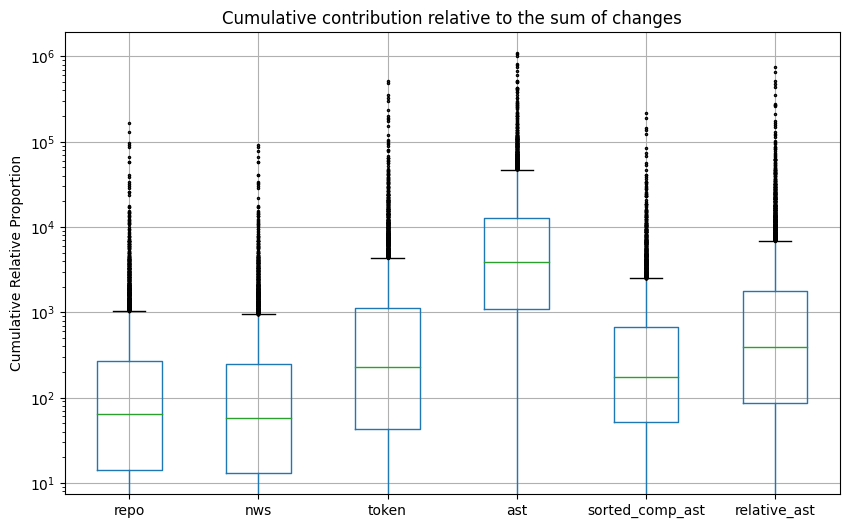

In [15]:
plt.figure(figsize=(10, 6))
df.boxplot(whis=3, flierprops={'markersize': 3, 'marker': '.'})
plt.yscale('log')
plt.ylabel('Cumulative Relative Proportion')
plt.title("Cumulative contribution relative to the sum of changes")
plt.show()

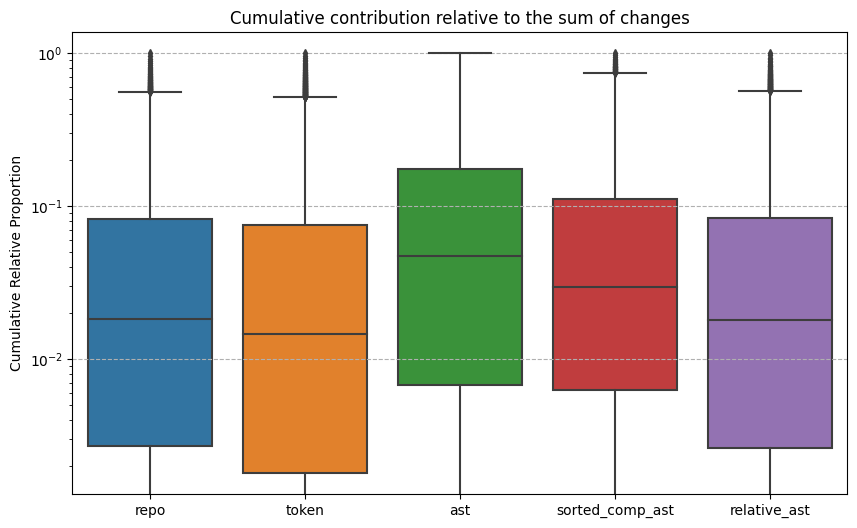

In [18]:
import seaborn as sns

df_relative = df[['repo', 'token', 'ast', 'sorted_comp_ast', 'relative_ast']].cumsum()/(df[['repo', 'token', 'ast', 'sorted_comp_ast', 'relative_ast']].sum())
plt.figure(figsize=(10, 6))
sns.boxplot(data=df_relative, whis=6, fliersize=4)
plt.yscale('log')
plt.ylabel('Cumulative Relative Proportion')
plt.title("Cumulative contribution relative to the sum of changes")
ax = plt.gca()
ax.yaxis.grid(True, ls="--")   
plt.show()

<Axes: >

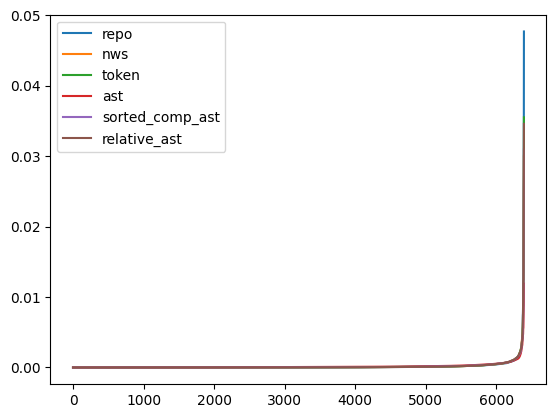

In [7]:
(df / df.sum()).plot()

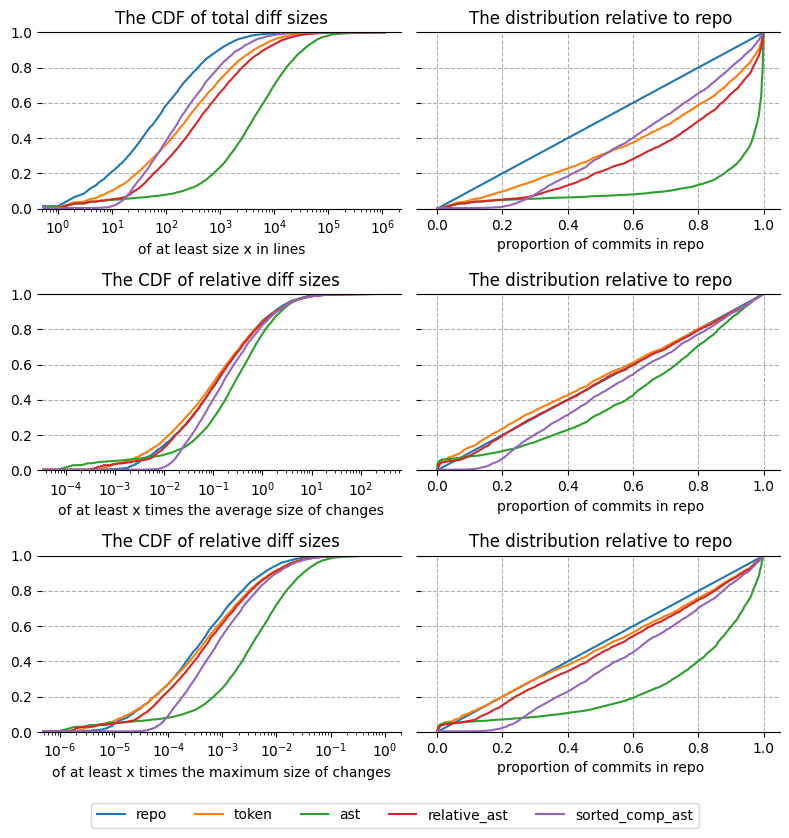

In [12]:
# Setting up the plots
fig, axes = plt.subplots(3,2, sharey=True, figsize=(8,8))
axes = axes.flatten()
args = {"legend" : False, "ylim" : (0,1)}

# 1.	 CDF of total diff sizes

keys = ["repo", "token", "ast", "relative_ast", "sorted_comp_ast"]

data = {}

for key in keys:
    df_x = pd.DataFrame(data = {key : df.index/(len(df.index)-1)}, index = df[key])
    df_x = df_x.groupby(df_x.index).max()
    data[key] = df_x[key]
    
cdf_tot = pd.DataFrame(data = data).interpolate() # .fillna(method="ffill").fillna(0)
cdf_tot.plot(ax=axes[0], title="The CDF of total diff sizes", xlabel="of at least size x in lines", **args)
axes[0].set_xscale('log')
cdf_tot.repo = cdf_tot.repo.fillna(0)

# 2.	 Distribution of the previous CDF relative to repo
p_p = cdf_tot.set_index("repo").assign(repo = cdf_tot.repo.values)
p_p[keys].plot(ax=axes[1], title="The distribution relative to repo", xlabel="proportion of commits in repo", **args)
axes[1].xaxis.grid(True, ls="--")

# 3.	 CDF of relative diff sizes with average size of changes
data = {}

for key in keys:
    df_x = pd.DataFrame(data = {key : df.index/(len(df.index)-1)}, index = df[key] / df[key].mean())
    df_x = df_x.groupby(df_x.index).max()
    data[key] = df_x[key]
    
cdf_rel = pd.DataFrame(data = data).interpolate() # .fillna(method="ffill").fillna(0)
cdf_rel.plot(ax=axes[2],title="The CDF of relative diff sizes", xlabel="of at least x times the average size of changes", **args)
axes[2].xaxis.set_major_formatter(lambda y,z: f"{y*100:0.0f}%")
axes[2].set_xscale('log')

# 4.	 Distribution of the previous CDF relative to repo
cdf_rel.repo = cdf_rel.repo.fillna(0)
p_p = cdf_rel.set_index("repo").assign(repo = cdf_rel.repo.values)
p_p[keys].plot(ax=axes[3], title="The distribution relative to repo", xlabel="proportion of commits in repo", **args)
axes[3].xaxis.grid(True, ls="--")

# 5.	 CDF of relative diff sizes with maximum size of changes
data = {}

for key in keys:
    df_x = pd.DataFrame(data = {key : df.index/(len(df.index)-1)}, index = df[key] / max(df[key]))
    df_x = df_x.groupby(df_x.index).max()
    data[key] = df_x[key]
    
cdf_rel = pd.DataFrame(data = data).interpolate() # .fillna(method="ffill").fillna(0)
cdf_rel.plot(ax=axes[4],title="The CDF of relative diff sizes", xlabel="of at least x times the maximum size of changes", **args)
axes[4].xaxis.set_major_formatter(lambda y,z: f"{y*100:0.0f}%")
axes[4].set_xscale('log')

# 6.	 Distribution of the previous CDF relative to repo
cdf_rel.repo = cdf_rel.repo.fillna(0)
p_p = cdf_rel.set_index("repo").assign(repo = cdf_rel.repo.values)
p_p[keys].plot(ax=axes[5], title="The distribution relative to repo", xlabel="proportion of commits in repo", **args)
axes[5].xaxis.grid(True, ls="--")

# Setting up the labels and positions
handles, labels = axes[5].get_legend_handles_labels()
fig.legend(handles, labels, loc='lower center', bbox_to_anchor=(0.5, -0.05), ncol=len(labels))
fig.tight_layout()

for ax in axes:
    ax.yaxis.grid(True, ls="--")
    ax.spines["right"].set_visible(False)
    ax.spines["left"].set_visible(False)

In [7]:
df

,repo,nws,token,ast,sorted_comp_ast,relative_ast
0,1,0,0,0,0,0
1,1,0,0,0,0,0
2,1,0,0,2,4,2
3,1,0,1,2,6,2
4,1,1,2,2,7,2
...,...,...,...,...,...,...
674,2766,2674,12591,35678,11090,18085
675,5102,5102,16757,62609,11124,25790
676,6784,6784,25364,96036,13169,35678
677,12654,12642,39860,116836,27455,56169


<Axes: >

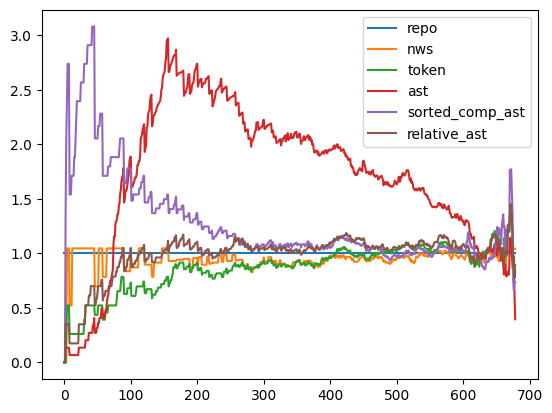

In [8]:
m = df.sum()
dt = df/m
dt.div(dt.repo, axis=0).plot()

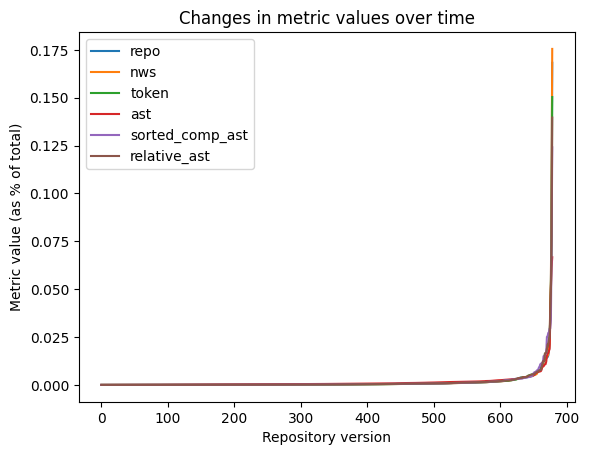

In [9]:
import matplotlib.pyplot as plt

(df[['repo','nws', 'token', 'ast', 'sorted_comp_ast', 'relative_ast']] / df[['repo', 'nws', 'token', 'ast', 'sorted_comp_ast', 'relative_ast']].sum()).plot(kind='line')
plt.xlabel('Repository version')
plt.ylabel('Metric value (as % of total)')
plt.title('Changes in metric values over time')
plt.show()


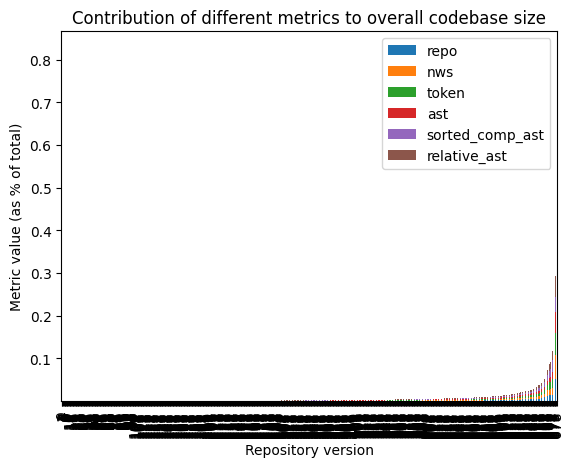

In [10]:
import matplotlib.pyplot as plt

(df[['repo', 'nws', 'token', 'ast', 'sorted_comp_ast', 'relative_ast']] / df[['repo', 'nws', 'token', 'ast', 'sorted_comp_ast', 'relative_ast']].sum()).plot(kind='bar', stacked=True)
plt.xlabel('Repository version')
plt.ylabel('Metric value (as % of total)')
plt.title('Contribution of different metrics to overall codebase size')
plt.show()


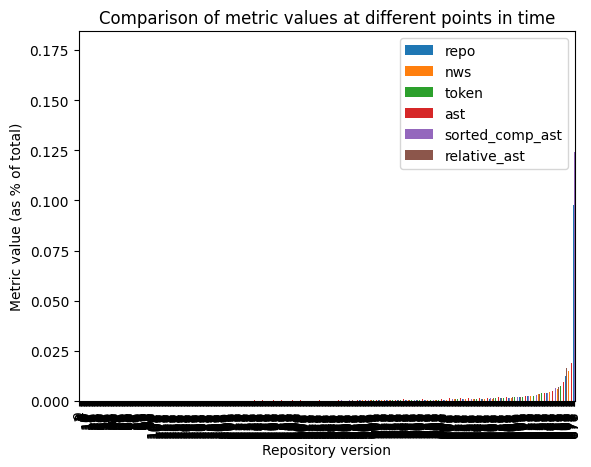

In [11]:
import matplotlib.pyplot as plt

(df[['repo', 'nws', 'token', 'ast', 'sorted_comp_ast', 'relative_ast']] / df[['repo', 'nws', 'token', 'ast', 'sorted_comp_ast', 'relative_ast']].sum()).plot(kind='bar')
plt.xlabel('Repository version')
plt.ylabel('Metric value (as % of total)')
plt.title('Comparison of metric values at different points in time')
plt.show()


Text(0.5, 1.0, 'Contribution of each commit (cumulative) to all commits')

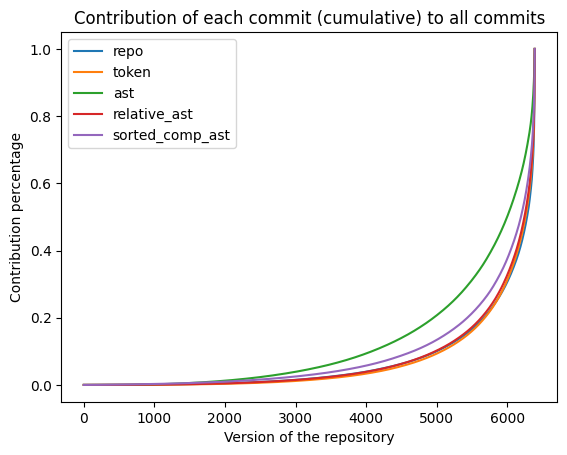

In [11]:
(df[['repo', 'token', 'ast', 'relative_ast', 'sorted_comp_ast']].cumsum() / df[['repo', 'token', 'ast', 'relative_ast', 'sorted_comp_ast']].sum()).plot()
plt.xlabel('Version of the repository')
plt.ylabel('Contribution percentage')
plt.title('Contribution of each commit (cumulative) to all commits')

<Axes: >

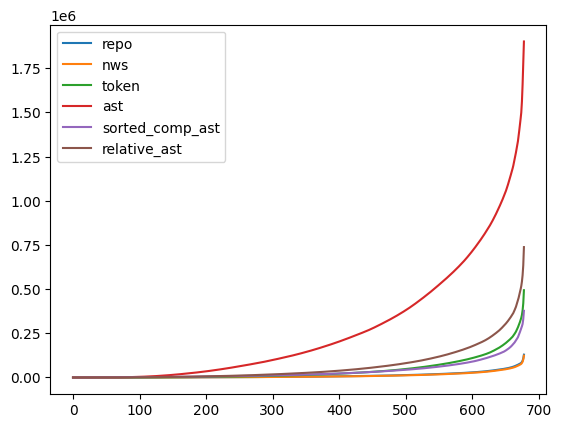

In [13]:
df.cumsum().plot()

In [14]:
#find størrelsen af filen for at finde en relativ ændring 
df_merged[df_merged.repo != 0][df_merged.nws == 0]

,repo,nws,token,ast,sorted_comp_ast,relative_ast
commit_hash,,,,,,
176ac0447b2e1f36f9a2ec7ad98381e5d0b22929,374,0,46,46,74,46
339e4f425c69021568eb7ed6d78d119272b6e7e4,18,0,0,0,0,0
70eecd6f6987d55ca114c0668068395033c8f5c0,2,0,2,2,34,2
83767338c31d8c05e81086c478cb104a74418f3a,464,0,0,136,192,136


In [15]:
df_merged / df_merged.sum()

,repo,nws,token,ast,sorted_comp_ast,relative_ast
commit_hash,,,,,,
00083d13d83f7f0ea017aa32c8cf7596ea765ccc,0.000147,0.000154,0.000101,0.000063,0.000151,0.000106
013ebc5201879fed02a9039a8872b81b05a45c36,0.000062,0.000049,0.000040,0.000656,0.000087,0.000064
018a3b846deb448af0a52d09bba57ad07e143c37,0.000085,0.000089,0.000099,0.000203,0.000079,0.000115
02a3e2119c07e693c4afd89da21d5b68eb7132b8,0.000070,0.000073,0.000040,0.000291,0.000183,0.000050
02fcf52f1b95ad944f40a1ba2938d1672f2ef05a,0.039486,0.041319,0.010331,0.061436,0.015099,0.007673
...,...,...,...,...,...,...
feb2ae2b64517eab2dc069672798ba8be3bd60e9,0.001958,0.002000,0.002181,0.003416,0.001828,0.002205
fec2db748bc092b99f80238c4be417563b0fa101,0.001053,0.001085,0.002316,0.000931,0.001399,0.002462
fec64b89f3bd68a0248ce6c940995ac11fedb272,0.001347,0.001409,0.001693,0.001504,0.001370,0.001731
